<h3>Step #0. Fire the system</h3>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import plotly.graph_objects as go # for visualization
import os
import sys 
sys.path.append("../../Function/")
import function 

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
# from keras.optimizers import ADAM

<h3>Step #1. Read data</h3>

In [3]:
# Importing Training Set
df = pd.read_excel('../../../site_info_ver_4_lite.xlsx')

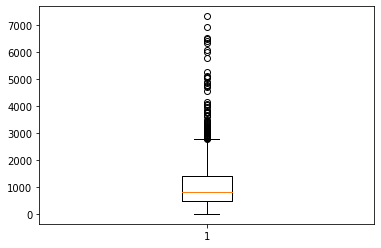

In [4]:
dataset = df.copy()
dataset = dataset.loc[(dataset['Site_Name']==dataset.Site_Name.unique()[2]) ]
site_name = dataset.Site_Name.unique()[0]
# dataset_train.set_index("Date",inplace=True)
dataset[['so2','nox','pm10','pm2.5', 'is_Site_exceeded_nox', 'is_Site_exceeded_so2', 'is_Site_exceeded_pm10', 'is_Site_exceeded_pm2.5']].isna().sum()
dataset.drop(['so2','nox','pm10','pm2.5','is_Site_exceeded_nox', 'is_Site_exceeded_so2', 'is_Site_exceeded_pm10', 'is_Site_exceeded_pm2.5','Day_before_Total','Tourists_Count', 'Total'],axis=1,inplace=True)
dataset = function.remove_unique_one(dataset)
dataset = function.remove_high_corr(dataset, 'Israelis_Count')
dataset = function.remove_outliers(dataset , 'Israelis_Count')
dataset = function.split_date(dataset)
tmp = dataset.Israelis_Count
dataset.drop('Israelis_Count',axis=1,inplace=True)
dataset['Israelis_Count']=tmp

<h5>Get past information from year before</h5>

In [5]:
def last_year_entries_info(dataframe,target):
    #get last year info
    dataframe['Last_year_visitors'] = dataframe.apply(lambda row : last_year_visitors(dataframe,row['day'],row['month'],row['year'],target) , axis = 1)
    
    #make use of group day to fill null values based on avg 
    groups = make_groups(dataframe , target)
    
    #getting the indexes where its null
    mask = dataframe['Last_year_visitors'].isna()
    #fill the nulls
    dataframe.loc[mask, 'Last_year_visitors'] = dataframe.loc[dataframe['Last_year_visitors'].isna()].apply(lambda row :fill_last_year_nulls(groups,row['day'],row['month'],target),axis=1)

    return dataframe


In [6]:
import datetime

def make_groups(dataframe,target):
    #getting the mean value for every day and month. it returns a dataframe of the results.
    return dataframe.groupby(['day','month'])[target].mean().reset_index()

def fill_last_year_nulls(groups,day,month,target):
    #fill the nulls from the groups we made
    return int(groups.loc[(groups['day'] == day) & (groups['month'] == month)][target])


def last_year_visitors(dataframe,day,month,year,target):
    #Extract the visitors 
    visitors_last_year = dataframe.loc[(dataframe['day'] == day) &(dataframe['month'] == month) & (dataframe['year'] == year-1)][target]    
    #Return the value
    if visitors_last_year.empty:
        return None
    else : return int(visitors_last_year)

# dataset['Last_year_visitors'] = dataset.apply(lambda row : last_year_visitors(dataset,row['day'],row['month'],row['year'],'Israelis_Count') , axis = 1)


In [7]:
dataset = last_year_entries_info(dataset,'Israelis_Count')

In [8]:
cols = dataset.columns.tolist()
extra_col = cols[-1]
cols = cols[:-1]
cols.insert(-1 , extra_col)
print(cols)
dataset = dataset[cols]

['Date', 'is_weekend', 'operations', 'is_jewish_holiday', 'is_muslims_holiday', 'Temperature', 'is_HeatWave', 'Haifa_pm10', 'Haifa_pm2.5', 'Jerusalem_nox', 'Beer-Sheva_nox', 'Tel_Aviv-Yafo_so2', 'Jerusalem_so2', 'Haifa_so2', 'Ashkelon_so2', 'Beer-Sheva_so2', 'Tel_Aviv-Yafo_pm10_exceeded', 'Haifa_pm10_exceeded', 'Ashkelon_pm10_exceeded', 'Tel_Aviv-Yafo_pm2.5_exceeded', 'Jerusalem_pm2.5_exceeded', 'Haifa_pm2.5_exceeded', 'Ashkelon_pm2.5_exceeded', 'Beer-Sheva_pm2.5_exceeded', 'Tel_Aviv-Yafo_nox_exceeded', 'Jerusalem_nox_exceeded', 'Haifa_nox_exceeded', 'Ashkelon_nox_exceeded', 'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter', 'day', 'month', 'year', 'Last_year_visitors', 'Israelis_Count']


In [9]:
dataset=dataset.set_index('Date')

In [10]:
cols = list(dataset.columns)
TargetVariable=['Israelis_Count']
Predictors=cols[:-1]
 
X= dataset[Predictors].values
y= dataset[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
# TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X= PredictorScalerFit.transform(X)
y= np.log(y + 0.001)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1292, 35)
(1292, 1)
(555, 35)
(555, 1)


In [ ]:
from keras import backend
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=16, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(units=32, kernel_initializer='normal', activation='tanh'))
model.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(metrics='mean_squared_error', optimizer='adam', loss = [rmse])

# es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# tb = TensorBoard('logs')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 150, verbose=1 ,validation_data=(X_test,y_test), validation_split=0.2)

In [18]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100,150]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
 
######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 90.22537580986399
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 90.83038068706632
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 91.36998897480423
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 91.72252442211511
5 Parameters: batch_size: 5 - epochs: 150 Accuracy: 91.81843608933544
6 Parameters: batch_size: 10 - epochs: 5 Accuracy: 87.00291185571979
7 Parameters: batch_size: 10 - epochs: 10 Accuracy: 90.27534087565614
8 Parameters: batch_size: 10 - epochs: 50 Accuracy: 91.5363977026929
9 Parameters: batch_size: 10 - epochs: 100 Accuracy: 91.46242232672476
10 Parameters: batch_size: 10 - epochs: 150 Accuracy: 91.5852419893482
11 Parameters: batch_size: 15 - epochs: 5 Accuracy: 85.41060330638022
12 Parameters: batch_size: 15 - epochs: 10 Accuracy: 88.17800429089269
13 Parameters: batch_size: 15 - epochs: 50 Accuracy: 91.38427255351996
14 Parameters: batch_size: 15 - epochs: 100 Accuracy: 91.57294835092002
15 Parameters: batch

<AxesSubplot:xlabel='Parameters'>

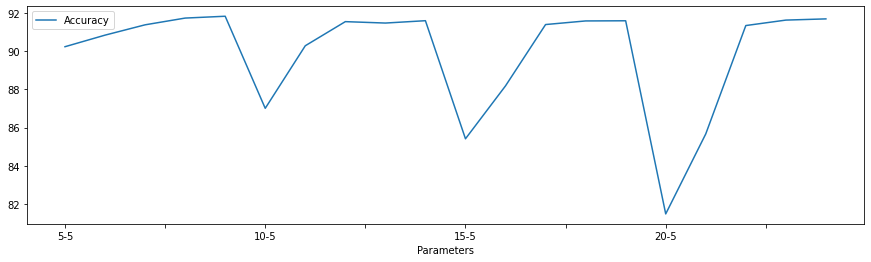

In [19]:

%matplotlib inline
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

In [20]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 5, epochs = 150, verbose=0)
# Generating Predictions on testing data
Predictions=model.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
Predictions=np.exp(Predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig=np.exp(y_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)
 
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Entries']=y_test_orig
TestingData['PredictedEntries']=Predictions
TestingData.head()

,is_weekend,operations,is_jewish_holiday,is_muslims_holiday,Temperature,is_HeatWave,Haifa_pm10,Haifa_pm2.5,Jerusalem_nox,Beer-Sheva_nox,...,Season_autumn,Season_spring,Season_summer,Season_winter,day,month,year,Last_year_visitors,Entries,PredictedEntries
0,0.0,0.0,0.0,1.0,23.442443,1.0,75.6,85.8,732.8,27.3,...,0.0,0.0,1.0,0.0,20.0,8.0,2020.0,1541.0,2148.001,1279.599121
1,1.0,0.0,1.0,0.0,17.000000,1.0,49.1,61.7,480.5,19.7,...,0.0,1.0,0.0,0.0,3.0,4.0,2021.0,2264.0,2747.001,1346.349365
2,0.0,0.0,0.0,0.0,24.835429,1.0,59.7,80.8,657.8,52.5,...,0.0,0.0,1.0,0.0,17.0,6.0,2020.0,296.0,504.001,511.335876
3,1.0,0.0,0.0,0.0,22.550060,1.0,76.4,95.0,199.5,32.0,...,1.0,0.0,0.0,0.0,31.0,10.0,2020.0,1744.0,2113.001,1311.971802
4,0.0,0.0,0.0,0.0,28.927328,1.0,87.7,110.4,974.7,30.8,...,1.0,0.0,0.0,0.0,24.0,10.0,2019.0,1094.0,1250.001,1035.300659


rmse 550.5238099922789
std test 629.5340923859318


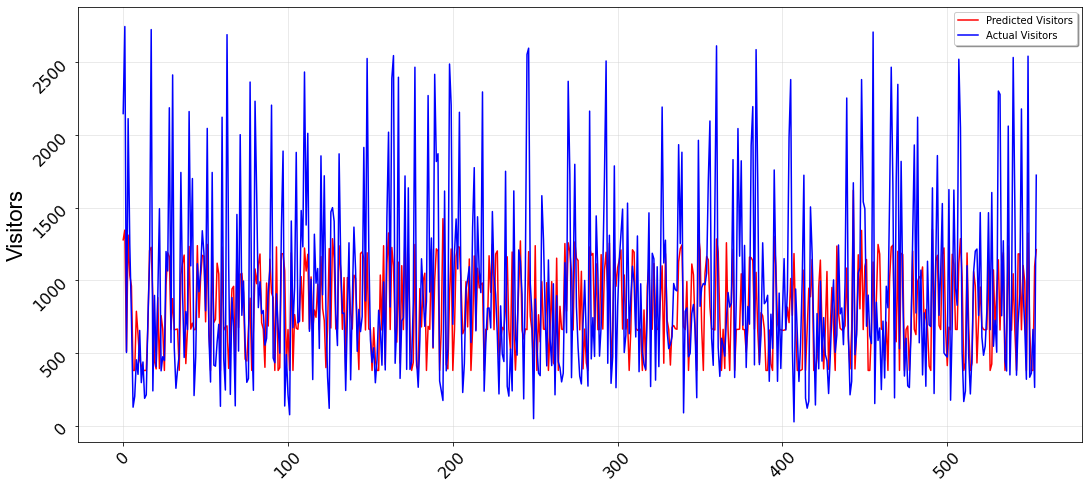

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


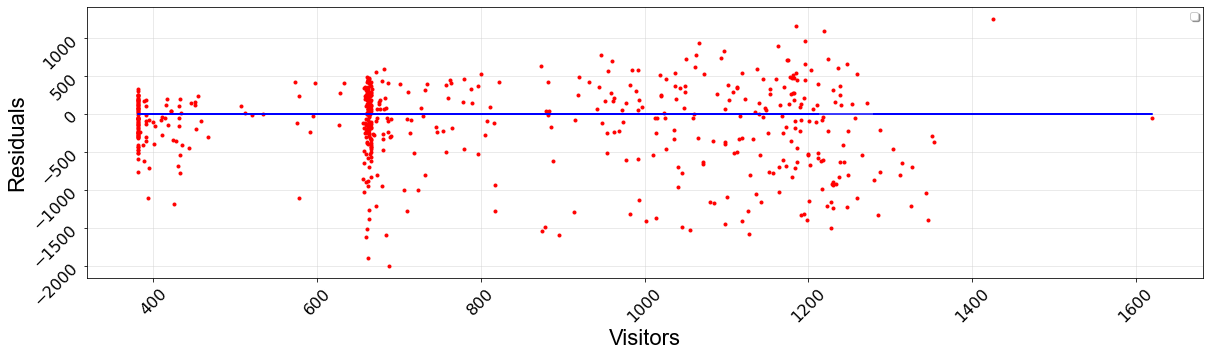

In [21]:
import warnings
warnings.filterwarnings('ignore')
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

TestingData['TestingDataiduals'] = TestingData['PredictedEntries'] - TestingData['Entries']

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(TestingData['PredictedEntries'],TestingData['Entries']))
print('rmse',rmse)
print('std test',np.std(TestingData['Entries']))

rmse_str = str(round(rmse,2))

# Check whether the specified path exists or not

function.plot_line(
  prediction=TestingData.PredictedEntries,
  actual=TestingData.Entries
  )

function.plot_residuals(
  prediction=TestingData.PredictedEntries,
  actual=TestingData.Entries,
  fig_size_tuple=(20,5)
  )

<h3>Step #6. Visualize the Predictions</h3>